<a href="https://colab.research.google.com/github/maira8009/Speech-Driven-Cardiac-Morbidity-Detection/blob/main/GeneratedECGfromSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_ecg = pd.read_csv(r'/content/final_ecg_features.csv')       # Columns: ecg_id, mean, std, min, max, ptp, skew, kurtosis
df_speech = pd.read_csv(r'/content/final_speech_features.csv')

In [5]:
ecg_features = df_ecg.iloc[:,1:].values   # shape (43, 8)
speech_features = df_speech.iloc[:,1:].values  # shape (n_speech, 9)

In [7]:
from sklearn.preprocessing import StandardScaler

# ===== STEP 1: Keep ONLY numeric columns =====
ecg_features = df_ecg.select_dtypes(include='number').to_numpy()
speech_features = df_speech.select_dtypes(include='number').to_numpy()

# ===== STEP 2: Normalize =====
scaler_ecg = StandardScaler()
ecg_scaled = scaler_ecg.fit_transform(ecg_features)

scaler_speech = StandardScaler()
speech_scaled = scaler_speech.fit_transform(speech_features)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [8]:
import pandas as pd
import numpy as np

df_speech_numeric = df_speech.select_dtypes(include='number')

# Drop columns with NaN or zero variance
df_speech_numeric = df_speech_numeric.dropna(axis=1)
df_speech_numeric = df_speech_numeric.loc[:, df_speech_numeric.std() != 0]

speech_features = df_speech_numeric.to_numpy()
speech_scaled = scaler_speech.fit_transform(speech_features)

In [9]:
# Convert to torch tensors
speech_tensor = torch.tensor(speech_scaled, dtype=torch.float32)
ecg_tensor = torch.tensor(ecg_scaled, dtype=torch.float32)

In [10]:
class SpeechECGDataset(Dataset):
    def __init__(self, speech, ecg):
        self.speech = speech
        self.ecg = ecg
        self.n = min(speech.shape[0], ecg.shape[0])  # Population-level alignment
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return self.speech[idx], self.ecg[idx]

dataset = SpeechECGDataset(speech_tensor, ecg_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [11]:
# ====== STEP 4: Define Simple Conditional Diffusion Network ======
class SimpleDiffusion(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleDiffusion, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.model(x)

input_dim = speech_tensor.shape[1]   # 9
output_dim = ecg_tensor.shape[1]     # 8
model = SimpleDiffusion(input_dim, output_dim)

In [12]:
# ====== STEP 5: Training ======
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 200

for epoch in range(epochs):
    for speech_batch, ecg_batch in dataloader:
        optimizer.zero_grad()
        pred_ecg = model(speech_batch)
        loss = criterion(pred_ecg, ecg_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 20/200, Loss: 0.0010
Epoch 40/200, Loss: 0.0057
Epoch 60/200, Loss: 0.0028
Epoch 80/200, Loss: 0.0009
Epoch 100/200, Loss: 0.0007
Epoch 120/200, Loss: 0.0006
Epoch 140/200, Loss: 0.0017
Epoch 160/200, Loss: 0.0141
Epoch 180/200, Loss: 0.0001
Epoch 200/200, Loss: 0.0005


In [15]:
with torch.no_grad():
    generated_ecg = model(speech_tensor).numpy()
    generated_ecg = scaler_ecg.inverse_transform(generated_ecg)  # Back to original scale

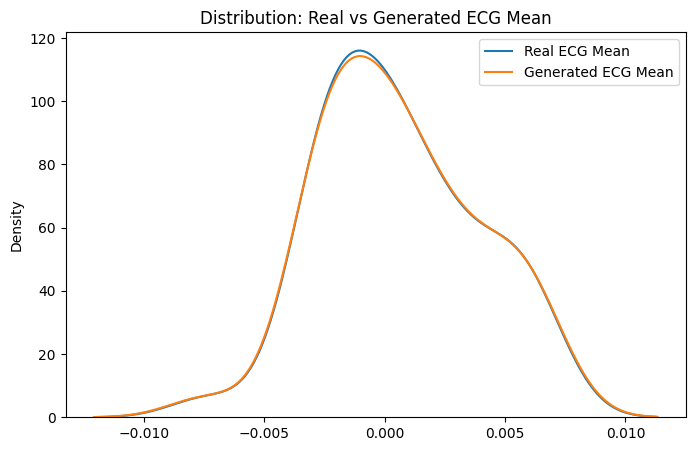

In [16]:
plt.figure(figsize=(8,5))
sns.kdeplot(ecg_features[:,0], label='Real ECG Mean')
sns.kdeplot(generated_ecg[:,0], label='Generated ECG Mean')
plt.title('Distribution: Real vs Generated ECG Mean')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

# Compare real vs generated ECG (all features)
mse = mean_squared_error(ecg_features, generated_ecg)
r2 = r2_score(ecg_features, generated_ecg)

print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


MSE: 0.0017
R2 Score: 0.9997


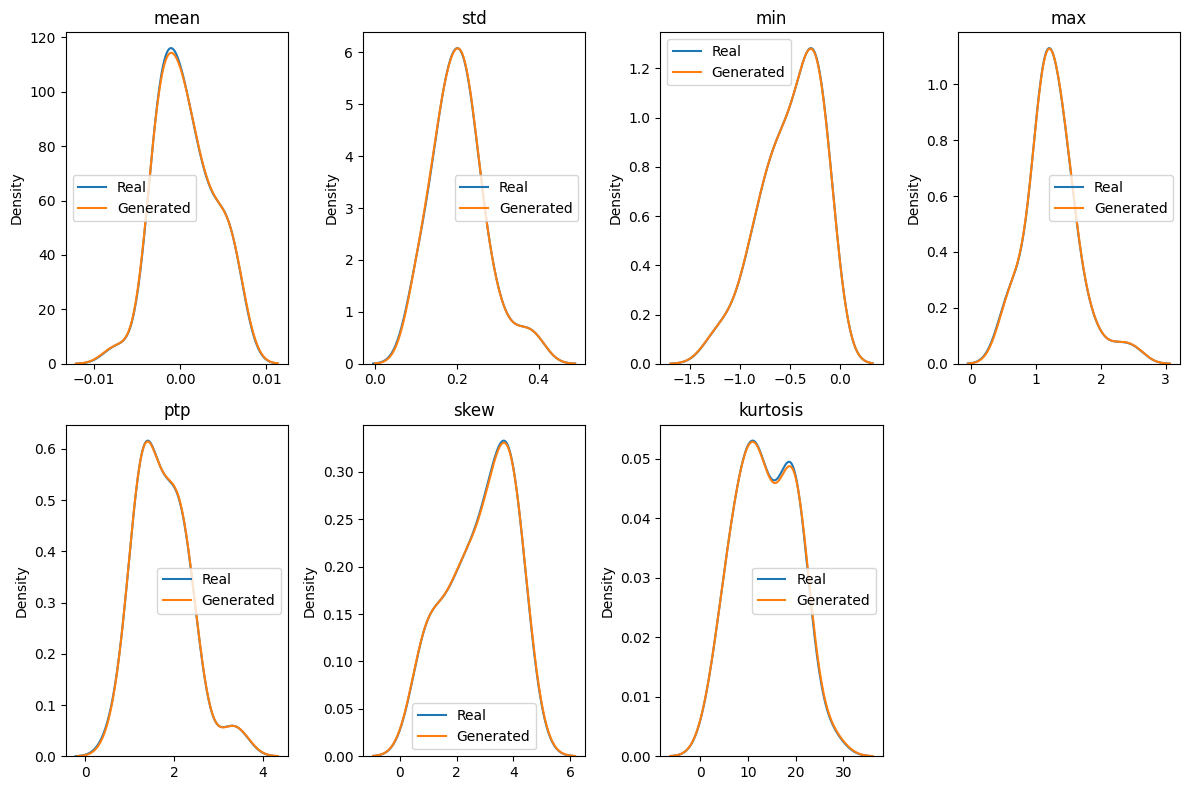

In [18]:
feature_names = df_ecg.columns[1:]  # skip ecg_id

plt.figure(figsize=(12,8))
for i, name in enumerate(feature_names):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(ecg_features[:,i], label='Real')
    sns.kdeplot(generated_ecg[:,i], label='Generated')
    plt.title(name)
    plt.legend()
plt.tight_layout()
plt.show()


In [19]:
df_generated_ecg = pd.DataFrame(generated_ecg, columns=df_ecg.columns[1:])
df_generated_ecg.to_csv('generated_ecg.csv', index=False)


In [20]:
import pandas as pd

# speech_scaled is a NumPy array
df_speech_scaled = pd.DataFrame(speech_scaled)

# Save to CSV
df_speech_scaled.to_csv('speech_scaled.csv', index=False)
print("Saved normalized speech features to speech_scaled.csv")

# Similarly, save generated ECG
df_generated_ecg = pd.DataFrame(generated_ecg)
df_generated_ecg.to_csv('generated_ecg.csv', index=False)
print("Saved generated ECG features to generated_ecg.csv")


Saved normalized speech features to speech_scaled.csv
Saved generated ECG features to generated_ecg.csv
